05 学習アルゴリズムの実装
=====================

* ここでは、これまでの復習を行う

### 前提

* ニューラルネットワークは、適用可能な重みとバイアスがある

* `学習`：この重みとバイアスを訓練データに適応するように調整すること

### ステップ1(ミニバッチ)

* 訓練データの中からランダムに一部のデータを選び出す

* `ミニバッチ`：その選ばれたデータのこと

* ここでは、その`ミニバッチ`の損失関数の値を減らすことを目的とする

### ステップ2(勾配の算出)

* `ミニバッチ`の損失関数を減らすために、各重みパラメータの`勾配`を求める

* `勾配`：損失関数の値を最も減らす方向を示す

### ステップ3(パラメータの更新)

* 重みパラメータを勾配方向に微小量だけ更新する

### ステップ4(繰り返す)

* ステップ1、ステップ2、ステップ3、を繰り返す

* ニューラルネットワークの学習は、上の4つの手順による手法で行う

    * この方法は、`勾配降下法`によってパラメータを更新する方法だが、ここで使用するデータはミニバッチとして無作為に選ばれたデータを使用している
    
    * そのため、`確率的勾配降下法`と呼ばれる
    
        * `確率的`とは、「確率的に無作為に選び出した」と言う意味
        
        * そのため、これは「無作為に選び出したデータに対して行う勾配降下法」
        
        * ディープラーニングでは、`SGD`と言う名称で実装される

* 実際に、手書き数字を学習するニューラルネットワークを実装していく

    * ここでは2層のニューラルネットワーク(隠れ層が1層のネットワーク)を対象に、MNISTデータセットを使って学習を行う

## 1. 2層ニューラルネットワークのクラス

* 2層のニューラルネットワークを、一つのクラスとして実装する

    * このクラスを、`TwoLayerNet`と言う名前のクラスとする

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

* このクラスで使用する変数とメソッドを整理して示す

| 変数     | 説明                                                                                                                                                                                                             |                                                                                                                                                                                                                               |
| -------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `params` | ニューラルネットワークのパラメータを保持するディクショナリ変数(インスタンス変数)<br>`params['W1']`は1層目の重み、`params['b1']`は1層目のバイアス<br>`params['W2']`は2層目の重み、`params['b2']`は2層目のバイアス |                                                                                                                                                                                                                               |
|           `grads`                                                                                                                                                                                                          | 勾配を保持するディクショナリ変数(`numerical_gradient()`メソッドの返り値)<br>`grads['W1']`は一層目の重みの勾配、`grads['b1']`は1層目のバイアスの勾配<br>`grads['W2']`は2層目の重みの勾配、`grads['b2']`は2層目のバイアスの勾配 |

| メソッド                                               | 説明                                                                                                                         |
| ------------------------------------------------------ | ---------------------------------------------------------------------------------------------------------------------------- |
| `__init__(self, input_size, hidden_size, output_size)` | 初期化を行う<br>引数は頭から順に、<br>「入力層のニューロンの数」<br>「隠れ層のニューロンの数」<br>「出力層のニューロンの数」 |
| `predict(self, x)`                                     | 認識(推論)を行う<br>引数の`x`は画像データ                                                                                    |
| `loss(self, x, t)`                                     | 損失関数の値を求める<br>引数の`x`は画像データ、`t`は正解ラベル                                                               |
| `accuracy(self, x, t)`                                 | 認識精度を求める                                                                                                             |
| `numerical_gradient(self, x, t)`                       | 重みパラメータに対する勾配を求める                                                                                           |
| `gradient(self, x, t)`                                 | 重みパラメータに対する勾配を求める<br>`numerical_gradient()`の高速版                                                         |


* `TwoLayerNet`クラスには、インスタンス変数として`params`と`grads`と言うディクショナリの変数がある

    * `params`変数には重みパラメータが格納されており、1層目のパラメータは`params['W1']`に、NumPy配列として格納されている
    
    * また、1層目のバイアスは`params['b1']`のようにアクセスする

In [2]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
net.params['W1'].shape

(784, 100)

In [3]:
net.params['b1'].shape

(100,)

In [4]:
net.params['W2'].shape

(100, 10)

In [5]:
net.params['b2'].shape

(10,)

* 上のように`params`変数には、このネットワークに必要なパラメータが全て格納されている

    * そして、`params`変数に格納された重みパラメータが、「推論処理(フォワード処理)」で使われる
    
    * 推論処理は、次のように実行できる

In [6]:
x = np.random.rand(100, 784)
y = net.predict(x)

* また、`grads`変数には、`params`変数と対応するように、各パラメータの勾配が格納される

    * 例)`numerical_gradient()`メソッドを使って勾配を確認すると、`grads`変数に勾配情報が格納される

In [7]:
# ダミーの入力データ(100枚分)
x = np.random.rand(100, 784)

# ダミーの正解ラベル(100枚分)
t = np.random.rand(100, 10)

In [8]:
# 勾配を計算
grads = net.numerical_gradient(x, t)

In [9]:
grads['W1'].shape

(784, 100)

In [10]:
grads['b1'].shape

(100,)

In [11]:
grads['W2'].shape

(100, 10)

In [12]:
grads['b2'].shape

(10,)

* 続いて、`TwoLayerNet`のメソッドの実装を見てみる

* `__init__(self, input_size, hidden_size, output_size)`メソッド

    * クラスの初期化メソッド
    
    * 引数は先頭から順に,
        
        * 入力層のニューロンの数
        
        * 隠れ層のニューロンの数
        
        * 出力層のニューロンの数
        
* 手書き数字の認識を行う場合は、入力画像サイズが$28 \times 28$の計784個あり、出力は10個のクラスになる

    * そのため、引数の`input_size=784`、`output_size=10`と指定し、隠れ層の個数である`hidden_size`は適当な値を設定する
    
* また、この初期化メソッドでは、重みパラメータの初期化を行う

    * 重みパラメータの初期値をどのような値に設定するかと言う問題は、ニューラルネットワークの学習を成功させる上で重要
    
    * ここでは重みはガウス分布に従う乱数で初期化し、バイアスは`0`で初期化する

* `predict(self, x)`と`accuracy(self, x, t)`については、前章のニューラルネットワークの推論処理の実装とほとんど同じ

* `loss(self, x, t)`については、損失関数の値を計算するメソッド

    * このメソッドの実装は、`predict()`の結果と正解ラベルを元に、交差エントロピー誤差を求めるだけになる

* `numerical_gradient(self, x, t)`メソッドは、各パラメータの勾配を計算する

    * これは数値微分によって、各パラメータの損失関数に対する勾配を計算する
   

* `gradient(self, x, t)`は誤差逆伝搬法

    * 次の章で扱う

## 2. ミニバッチ学習の実装

* ニューラルネットワークの学習の実装は、前に説明したミニバッチ学習で行う

    * `ミニバッチ学習`：訓練データから無作為に一部のデータを取り出して、そのミニバッチを対象に、勾配法によりパラメータを更新する
    
    * `TwoLayerNet`クラスを対象に、MNISTデータセットを使って学習を行う

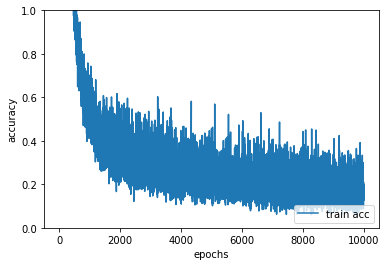

In [17]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
%matplotlib inline

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    grad = network.numerical_gradient(x_batch, t_batch)
#     grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
        
    # 学習経過の記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train acc')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')

* ここでは、ミニバッチのサイズを100として、毎回60,000個の訓練データからランダムに100個のデータ(画像データと正解ラベルデータ)を抜き出す

    * そしてその100個のミニバッチを対象に勾配を求め、確率勾配降下法(SGD)によりパラメータを更新する
    
    * ここでは勾配法による更新の回数を10000回として、更新するごとに、訓練データに対する損失関数を計算し、その値を配列に追加する
    
    *  これは上の図で表される

* 図より、学習の回数が進むにつれて、損失関数の値が減っていくことがわかる

    * これは、学習がうまくいっていることの証であり、ニューラルネットワークの重みパラメータが徐々にデータに適応していることがわかる
    
    * 繰り返しデータを浴びることによって、最適な重みパラメータへと徐々に近づいている

## 3. テストデータで評価

* ニューラルネットワークの学習では、訓練データ以外のデータを正しく認識できるかどうかを確認する必要がある

    * これは「過学習」を起こしていないかを確認するもの

* ニューラルネットワークの学習で目的にすることは、汎化能力を身に着けること

    * 汎化的な能力を評価するためには、訓練データに含まれないデータを使って評価する必要がある
    
    * 次の実装では、学習を行う過程で、定期的に訓練データとテストデータを対象に、認識精度を記録する
    
    * ここでは、1エポックごとに、訓練データとテストデータの認識精度を記録する

> `エポック`：単位を表す
>
> 「1エポック」とは、学習において訓練データを全て使い切った時の回数に対応する

train acc, test acc | 0.09893333333333333, 0.0959
train acc, test acc | 0.7788666666666667, 0.7832
train acc, test acc | 0.8773, 0.8795
train acc, test acc | 0.8973833333333333, 0.9022
train acc, test acc | 0.9073166666666667, 0.9109
train acc, test acc | 0.9142666666666667, 0.916
train acc, test acc | 0.91975, 0.921
train acc, test acc | 0.9236666666666666, 0.9271
train acc, test acc | 0.9275333333333333, 0.9279
train acc, test acc | 0.93095, 0.9302
train acc, test acc | 0.9343166666666667, 0.934
train acc, test acc | 0.9364166666666667, 0.9357
train acc, test acc | 0.9389, 0.9374
train acc, test acc | 0.9404666666666667, 0.939
train acc, test acc | 0.9428, 0.941
train acc, test acc | 0.9445666666666667, 0.9433
train acc, test acc | 0.9465666666666667, 0.9449


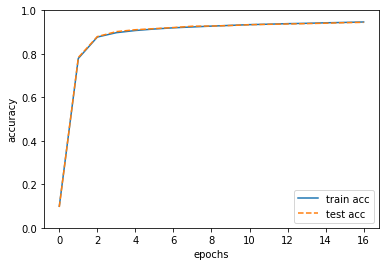

In [18]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')

* 上の例では1エポックごとに、全ての訓練データに対して認識精度を計算して、その結果を記録する

* 上の図では、訓練データの認識精度を実線で表し、テストデータの認識精度を破線で表している

    * エポックが進むにつれ、訓練データとテストデータを使って評価した認識精度は両方とも向上していることがわかる
    
    * また、その2つの認識精度には差がないことがわかる(過学習が起こっていない)

| 版   | 年/月/日   |
| ---- | ---------- |
| 初版 | 2019/05/04 |